In [49]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path
import matplotlib.pyplot as plt

In [50]:
# dir_ = Path('doro2/')
# filepaths = list(dir_.glob(r'*.jpg'))
filepaths=os.listdir("doro3")
def proc_img(filepath):
    """
    이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("_")[0] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,driveway_189.jpg,driveway
1,sidewalk_19.jpg,sidewalk
2,driveway_192.jpg,driveway
3,bicycleroad_135.jpg,bicycleroad
4,sidewalk_185.jpg,sidewalk


In [51]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 800

Number of different labels: 3

Labels: ['driveway' 'sidewalk' 'bicycleroad']


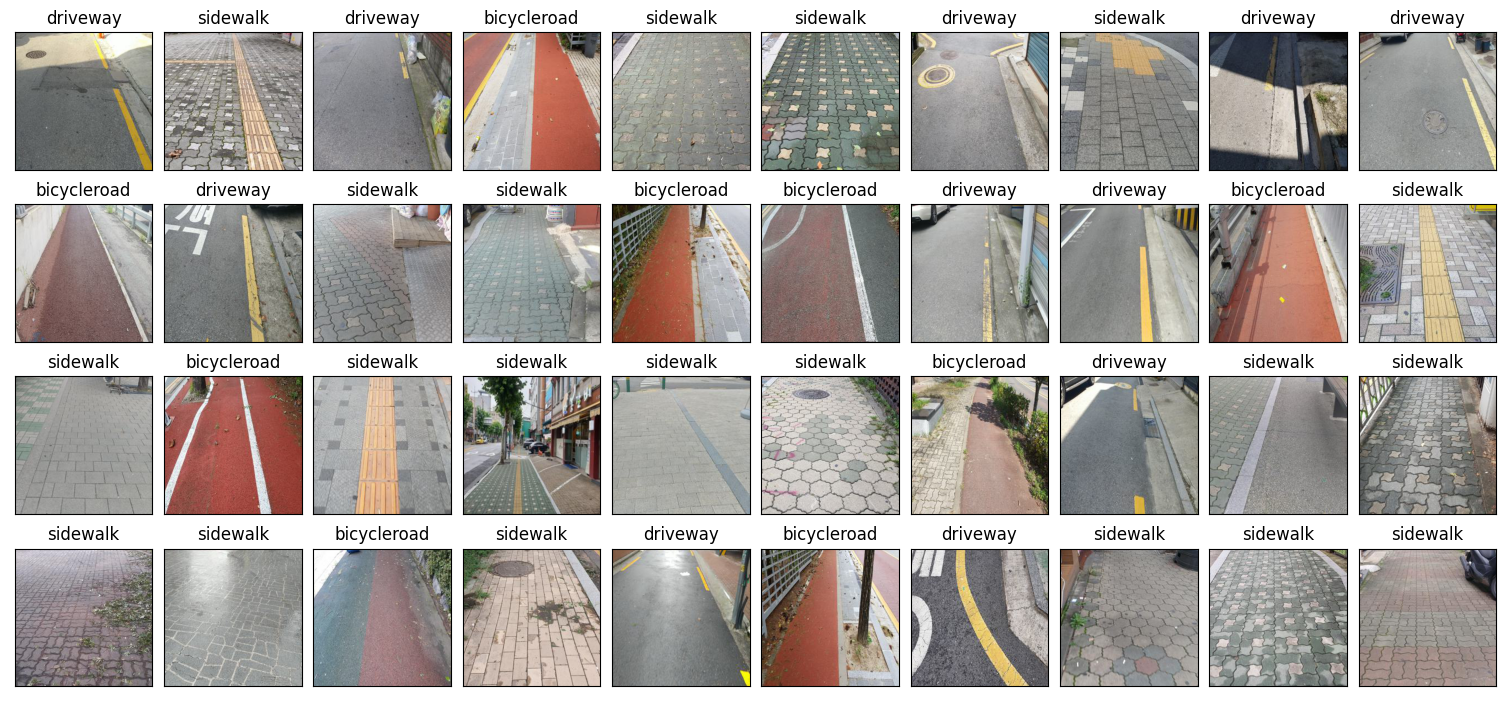

In [53]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread('doro3/'+df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
    
plt.tight_layout(pad=0.5)
plt.show()

In [73]:
# 이미지 크기가 제각각이라 맞춤
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [74]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df.shape,test_df.shape

((640, 2), (160, 2))

In [75]:
total_train = train_df.shape[0]  # train_df : 증식시켜야 할 데이터 
total_validate = test_df.shape[0]
batch_size=15

In [76]:
# 이미지 증식
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [77]:
# flow_from_dataframe
# train_df : 증식시켜야 할 데이터가 데이터프레임이므로
train_generator=train_datagen.flow_from_dataframe(
    train_df,
    "doro3/",
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 640 validated image filenames belonging to 3 classes.


In [78]:
train_generator.class_indices

{'bicycleroad': 0, 'driveway': 1, 'sidewalk': 2}

In [79]:
# validation 데이터는 증식하면 안됨
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    test_df, 
    "doro3/", 
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 160 validated image filenames belonging to 3 classes.


In [80]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 64)      

In [81]:
earlystop = EarlyStopping(patience=10) # 10번이상 모델이 개선되지 않으면 멈춤

In [82]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)  # learning_rate의 하한값

In [83]:
callbacks = [earlystop, learning_rate_reduction]

In [84]:
batch_size=15

In [85]:
history=model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\tjdbs\AppData\Local\Temp\ipykernel_26020\2548741774.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/50
42/42 [==============================] - 27s 620ms/step - loss: 1.1899 - accuracy: 0.5136 - val_loss: 0.7940 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 21s 493ms/step - loss: 0.8155 - accuracy: 0.6256 - val_loss: 0.7272 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 22s 520ms/step - loss: 0.7375 - accuracy: 0.6544 - val_loss: 0.6236 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 19s 453ms/step - loss: 0.5664 - accuracy: 0.7376 - val_loss: 0.5573 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 19s 460ms/step - loss: 0.6337 - accuracy: 0.7472 - val_loss: 0.5633 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 20s 464ms/step - loss: 0.4804 - accuracy: 0.8064 - val_loss: 0.3982 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 19s 457ms/st

42/42 [==============================] - 27s 645ms/step - loss: 0.1806 - accuracy: 0.9270 - val_loss: 0.1309 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 22/50
42/42 [==============================] - 26s 619ms/step - loss: 0.1822 - accuracy: 0.9232 - val_loss: 0.1667 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 23/50
42/42 [==============================] - 23s 525ms/step - loss: 0.1836 - accuracy: 0.9296 - val_loss: 0.1556 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 24/50
42/42 [==============================] - 29s 688ms/step - loss: 0.1873 - accuracy: 0.9344 - val_loss: 0.1388 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 25/50
42/42 [==============================] - 26s 608ms/step - loss: 0.1150 - accuracy: 0.9488 - val_loss: 0.0820 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 26/50
42/42 [==============================] - 24s 571ms/step - loss: 0.1286 - accuracy: 0.9520 - val_loss: 0.1105 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 27/50
42/42 [==============================] - 24s 575ms/step - 

Epoch 42/50
42/42 [==============================] - 21s 495ms/step - loss: 0.0771 - accuracy: 0.9696 - val_loss: 0.0550 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 43/50
42/42 [==============================] - 21s 503ms/step - loss: 0.0973 - accuracy: 0.9680 - val_loss: 0.0922 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 44/50
42/42 [==============================] - 20s 479ms/step - loss: 0.0952 - accuracy: 0.9664 - val_loss: 0.0374 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 45/50
42/42 [==============================] - 20s 481ms/step - loss: 0.0697 - accuracy: 0.9792 - val_loss: 0.0317 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 46/50
42/42 [==============================] - 22s 524ms/step - loss: 0.0527 - accuracy: 0.9824 - val_loss: 0.1527 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 47/50
42/42 [==============================] - 23s 555ms/step - loss: 0.1157 - accuracy: 0.9616 - val_loss: 0.0329 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 48/50
42/42 [==============================] - 21s 5

In [86]:
model.save("./cnn_model_3class_final.h5")

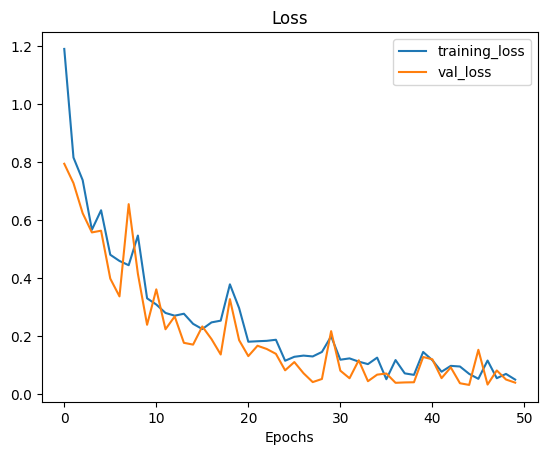

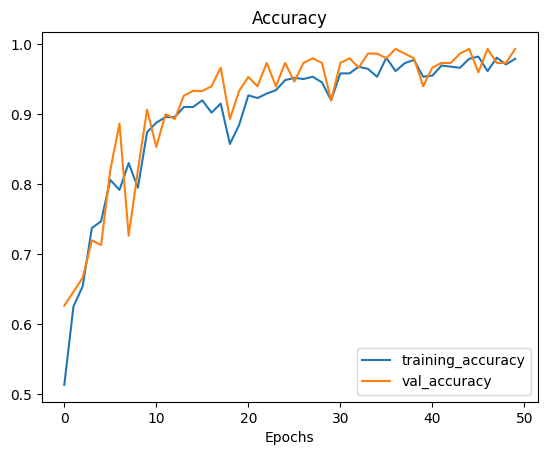

In [87]:
from helper_function import plot_loss_curves
plot_loss_curves(history)

In [88]:
from keras.models import load_model
model = load_model('cnn_model_3class_final.h5')

In [89]:
#test
test_filenames = os.listdir("cnn_test_img")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df

,filename
0,bicycleroad_107.jpg
1,bicycleroad_108.jpg
2,bicycleroad_109.jpg
3,bicycleroad_110.jpg
4,driveway1.jpg
5,driveway2.jpg
6,driveway3.jpg
7,driveway8.jpg
8,sidewalk1.jpg
9,sidewalk3.jpg


In [90]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "cnn_test_img/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224,224),
    batch_size=15,
    shuffle=False
)

Found 12 validated image filenames.


In [91]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/15))

C:\Users\tjdbs\AppData\Local\Temp\ipykernel_26020\2490667610.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/15))


In [92]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df

,filename,category
0,bicycleroad_107.jpg,0
1,bicycleroad_108.jpg,0
2,bicycleroad_109.jpg,0
3,bicycleroad_110.jpg,0
4,driveway1.jpg,1
5,driveway2.jpg,1
6,driveway3.jpg,2
7,driveway8.jpg,2
8,sidewalk1.jpg,2
9,sidewalk3.jpg,2


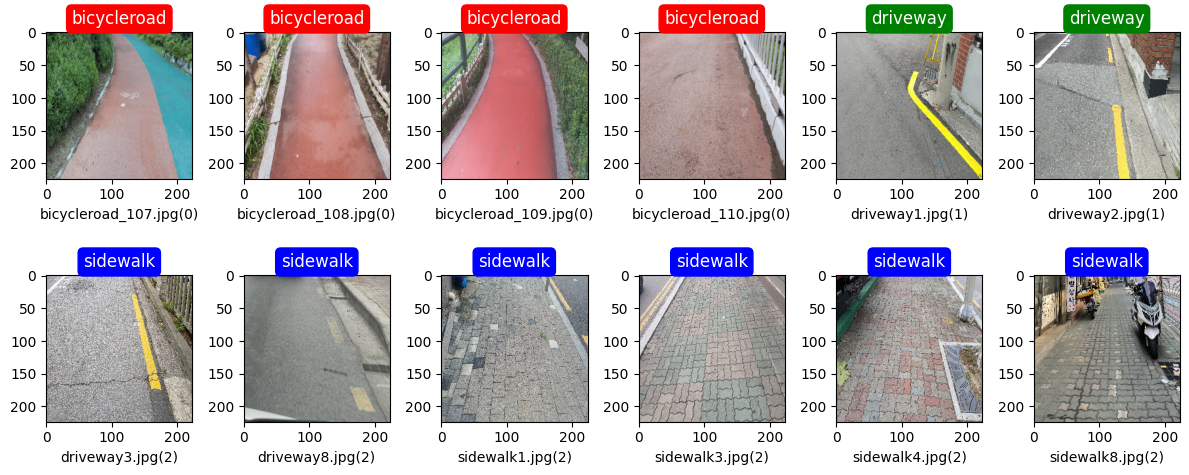

In [93]:
# {'bicycleroad': 0, 'driveway': 1, 'sidewalk': 2}
sample_test = test_df.head(14)
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("cnn_test_img/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(5, 6, index+1 )
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    
    if category==2:
        plt.title(f"sidewalk", color='white', 
                  bbox=dict(boxstyle="round", 
                            color='blue'))
    elif category==1:
         plt.title(f"driveway", color='white', 
                  bbox=dict(boxstyle="round", 
                            color='green'))
    else:
        plt.title(f"bicycleroad", color='white', 
          bbox=dict(boxstyle="round", 
                    color='red'))
plt.tight_layout()
plt.show()

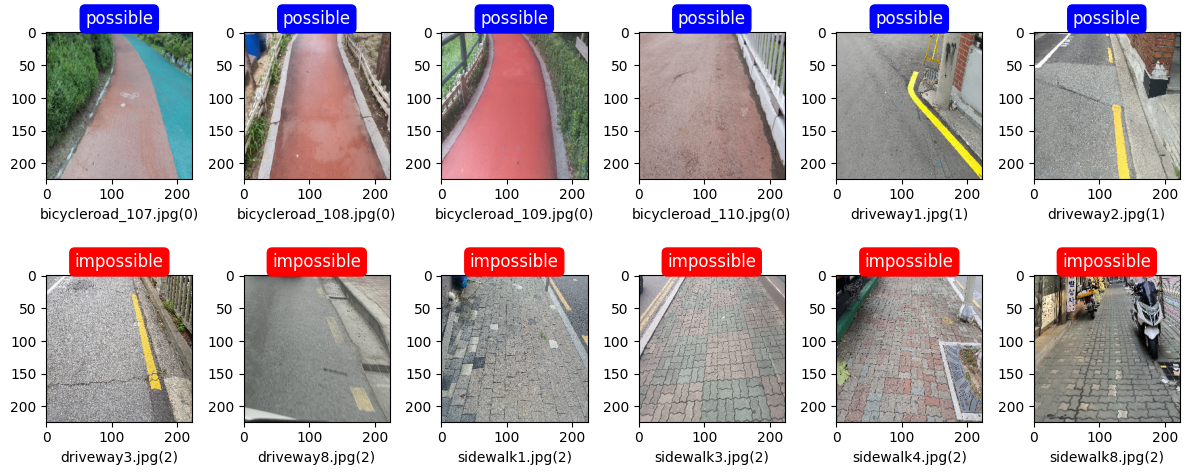

In [94]:
# {'bicycleroad': 0, 'driveway': 1, 'sidewalk': 2}
sample_test = test_df.head(14)
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("cnn_test_img/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(5, 6, index+1 )
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    
    if category==2:
        plt.title(f"impossible", color='white', 
                  bbox=dict(boxstyle="round", 
                            color='red'))
        
    elif category==1 or category==0:
         plt.title(f"possible", color='white', 
                  bbox=dict(boxstyle="round", 
                            color='blue'))

plt.tight_layout()
plt.show()

In [95]:
# 경보음 음성파일 출력 함수
from IPython.display import Audio 
def sound():
    display(Audio('alarm-no3.mp3', autoplay=True))

In [96]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('cnn_test_img/sidewalk3.jpg', target_size = (224,224))
#test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

# {'bicycleroad': 0, 'driveway': 1, 'sidewalk': 2}

if (result[0][0] == 1) or (result[0][1] == 1):
    print("주행 가능")

elif result[0][2] == 1:
    print("주행 불가능")
    sound()

1/1 [==============================] - 0s 135ms/step
주행 불가능
